In [1]:
from train import main
import torch
import torch_geometric
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pylab
import matplotlib
import numpy as np
import networkx as nx
import datasets
from visualization_utils import load_model, load_whole_dataset

In [36]:
model, config, train_loader, val_loader, test_loader, num_hops, device, final_emb_dim, dataset_wrapper = load_model("")
h_all, theta_all, batch_all, x_all, x_out_all, y_all, annot_all, y_all_nodes, edge_index_all, y_pred_all, out_all = load_whole_dataset(config, model, test_loader, final_emb_dim)


0it [00:00, ?it/s]


In [7]:
for data in test_loader:
    break
data.cuda()

DataBatch(x=[1538, 2], edge_index=[2, 4057], y=[64], num_nodes=1538, annotations=[1538], batch=[1538], ptr=[65])

In [8]:
out, x_out, theta, h = model(data.x, data.edge_index, data.batch)

C:\Users\jonas\AppData\Local\Temp\jonas_pyg\tmput_clung.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.module_5(x)


In [9]:
classes = torch.argmax(out, dim=-1)
theta_class = theta[data.batch, classes]
# check if shared theta network
if theta.shape[1] == 1:
    theta_class = theta.squeeze(1)
else:
    # [num_nodes_total]: theta corresponding to the chosen class for this sample for each node
    theta_class = theta[torch.arange(theta.shape[0]), classes[data.batch]].shape





IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [1538], [64]

Accuracy: 98.67%


C:\Users\jonas\AppData\Local\Temp\jonas_pyg\tmp7x0rdptc.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.module_5(x)


C:\Users\jonas\anaconda3\envs\HierarchicalClusters\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


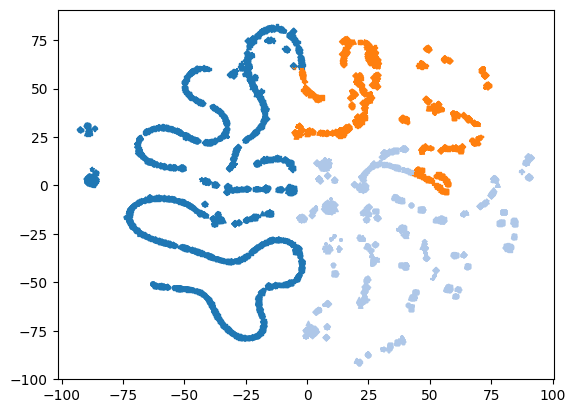

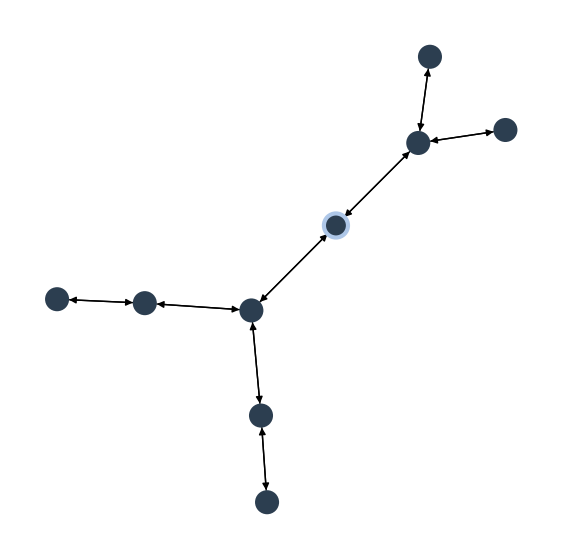

In [13]:


fig, ax = plt.subplots(figsize=(7,7))
draw_neighbourhood(ax, 800, edge_index_all, x_all)

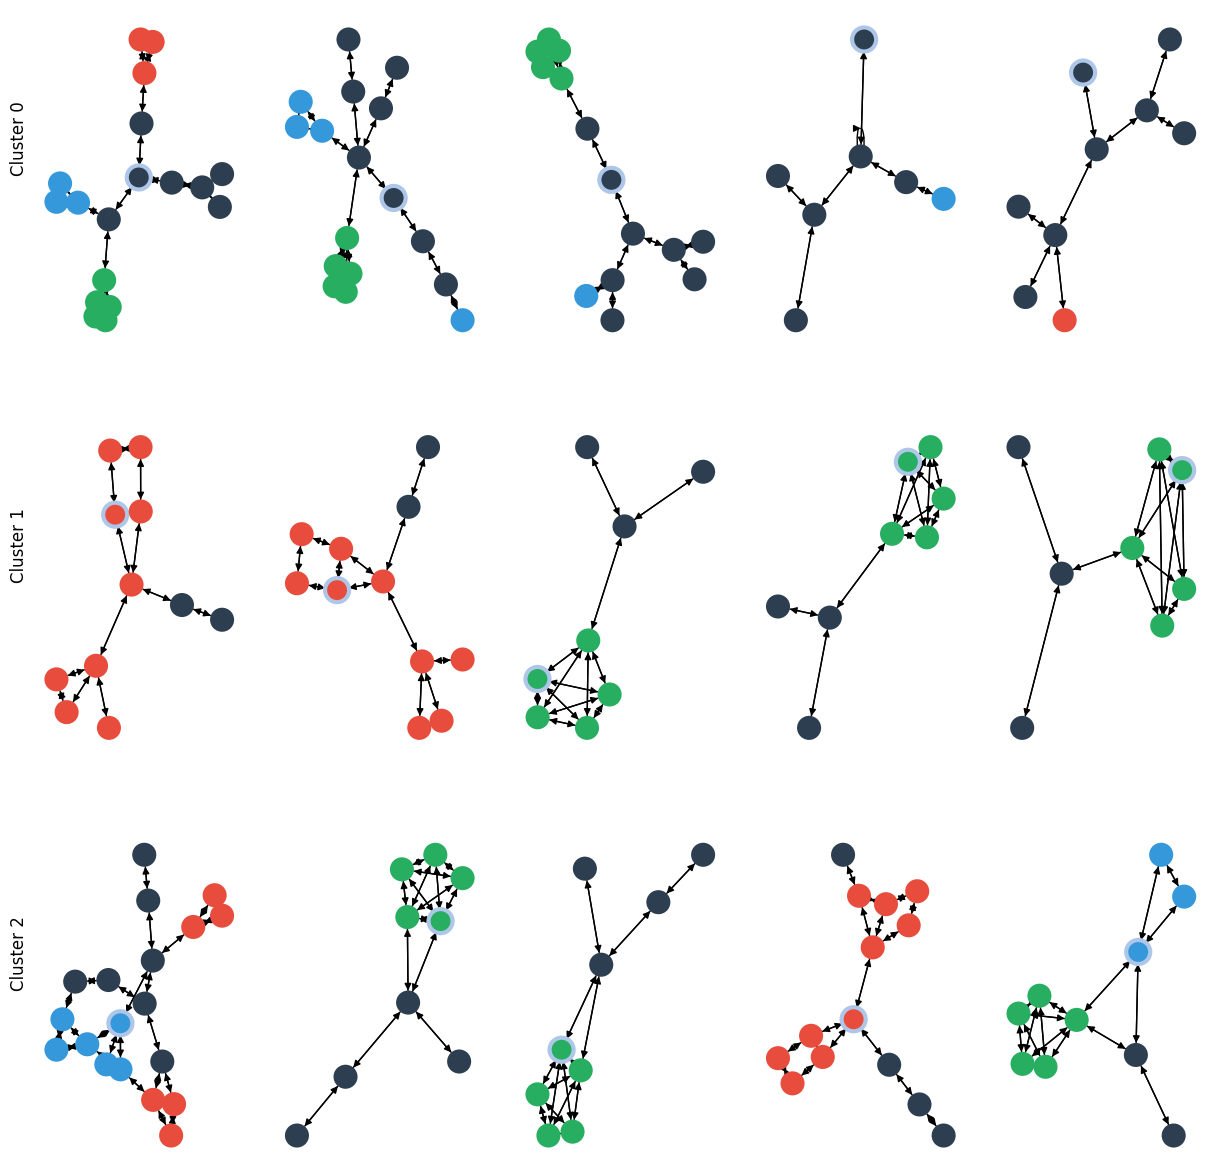

In [14]:


plot_closest_embeddings(kmeans.cluster_centers_, labels=[f"Cluster {i}" for i in range(kmeans.cluster_centers_.shape[0])])


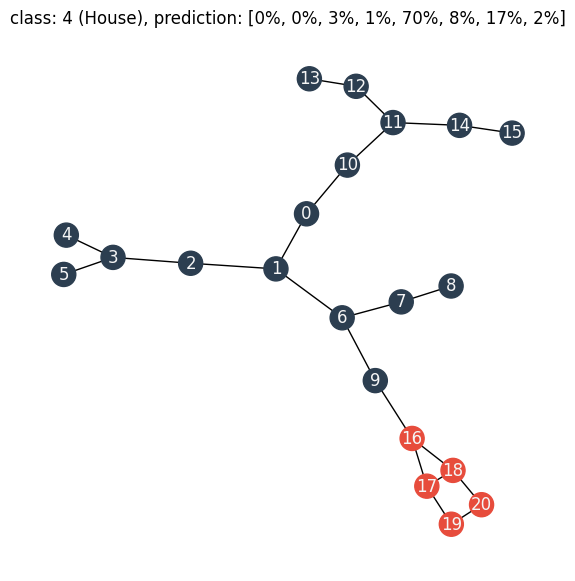

In [16]:



draw_graph(7)

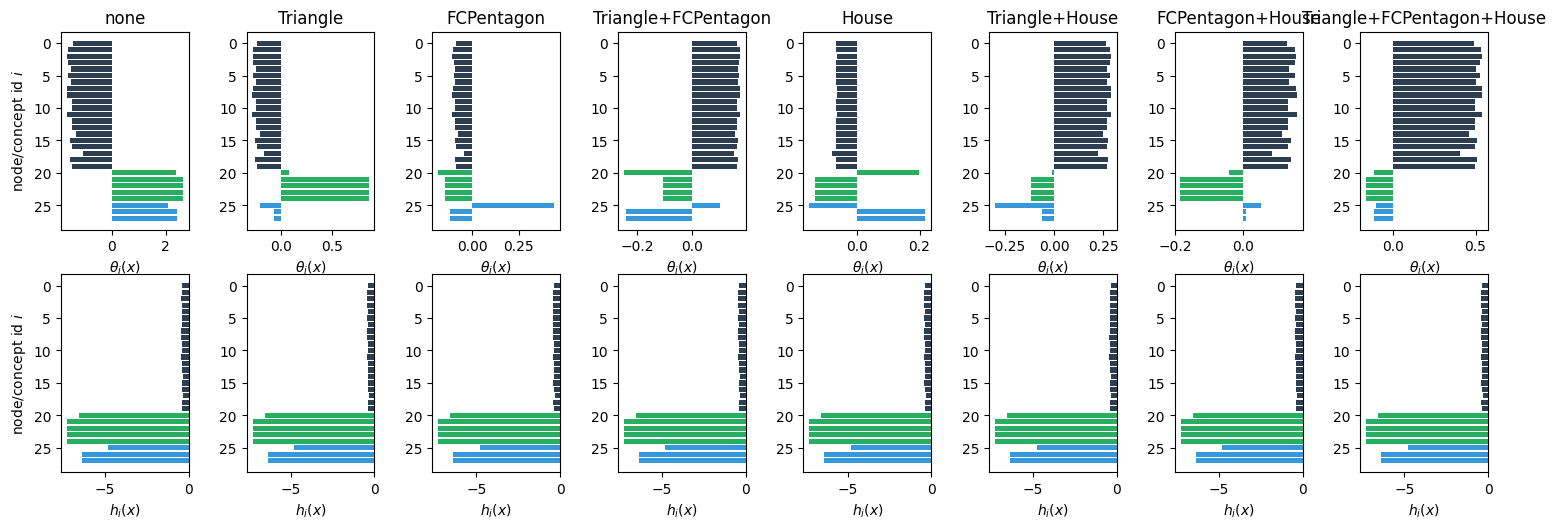

In [18]:



plot_theta_and_h(0)


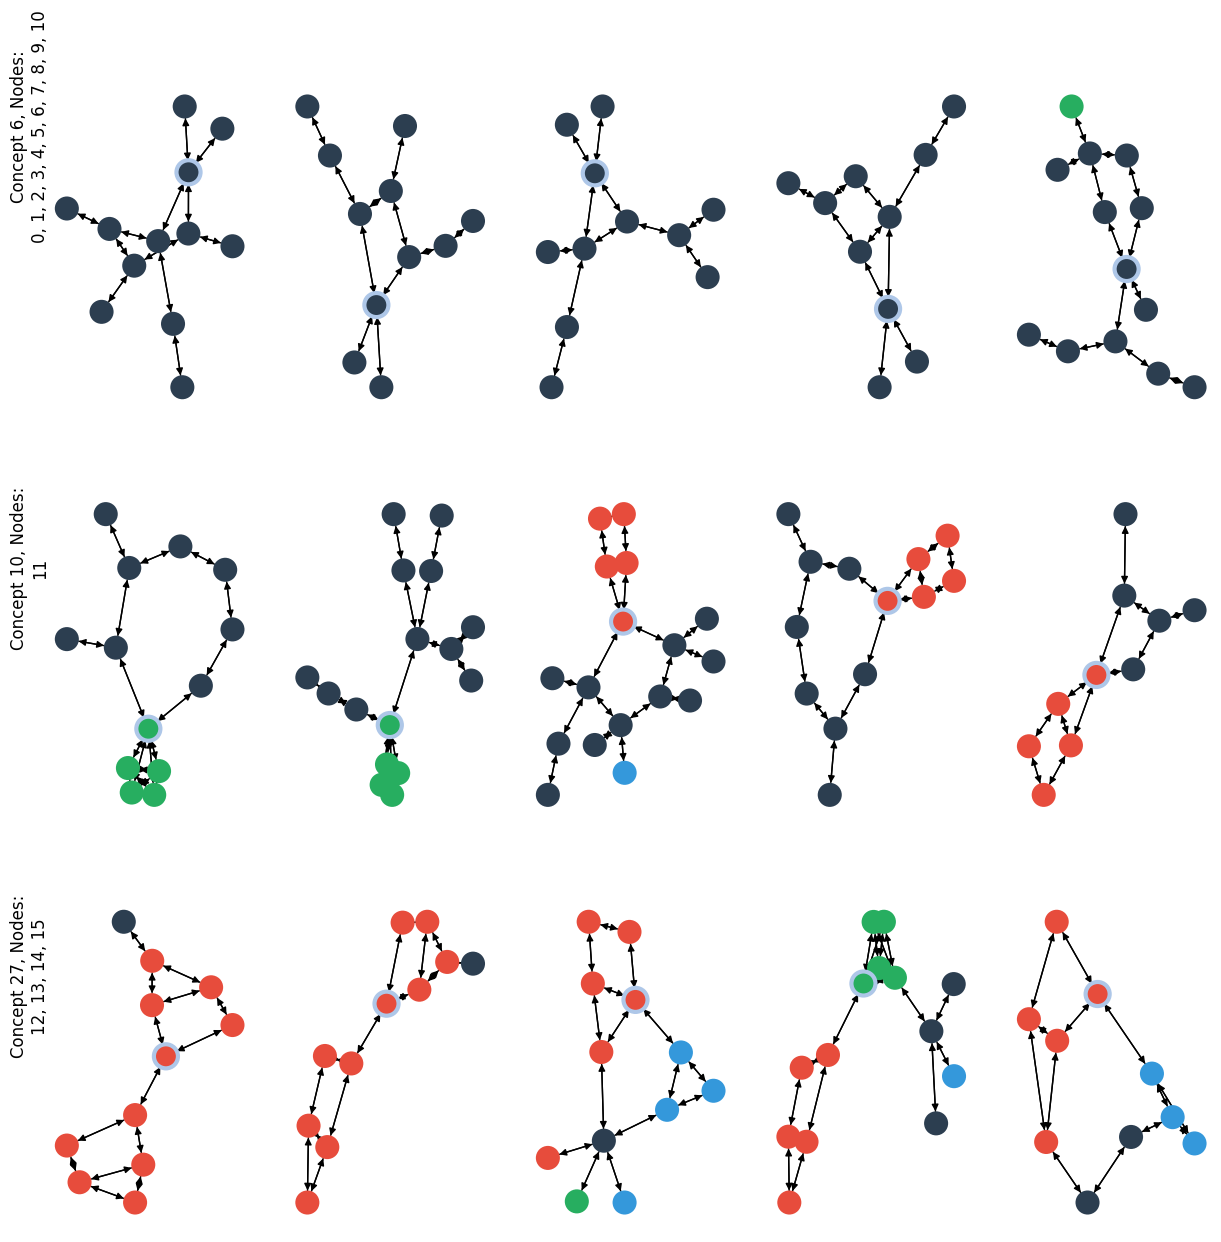

In [19]:

show_nearest_discretized(1)

In [ ]:
x_out_all[batch_all==1, :]

In [48]:
np.bincount(np.argmax(x_out_all, axis=1))

array([   0,    0,    0,    0,    0,    0, 3149,    0,    0,    0, 1725,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 1946], dtype=int64)

<BarContainer object of 28 artists>

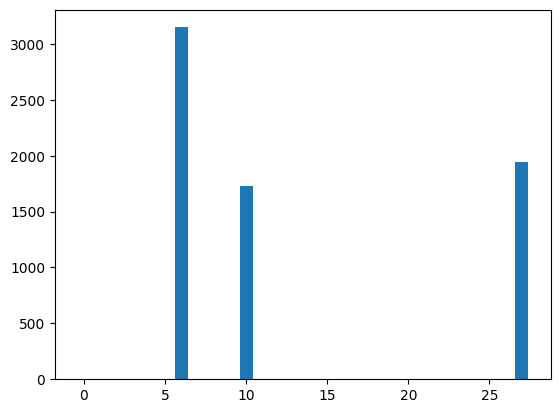

In [49]:
counts = np.bincount(np.argmax(x_out_all, axis=1))
fig, ax = plt.subplots()
ax.bar(np.arange(counts.shape[0]), counts)

# Analysis

In [38]:
sample = 0

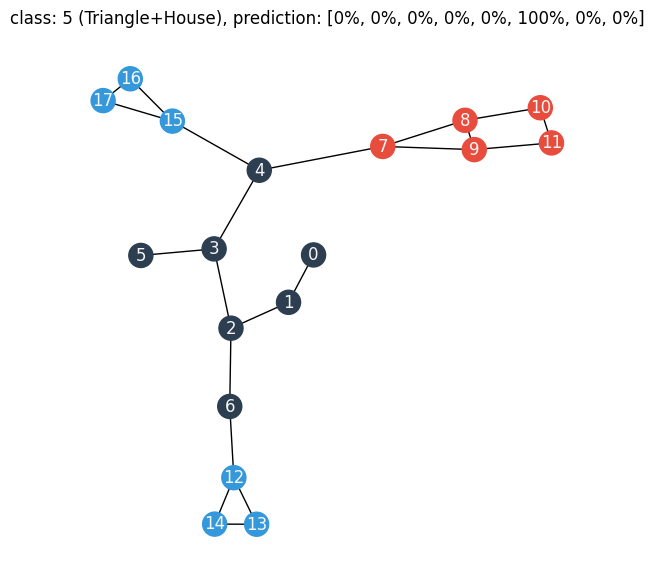

In [39]:
draw_graph(sample)

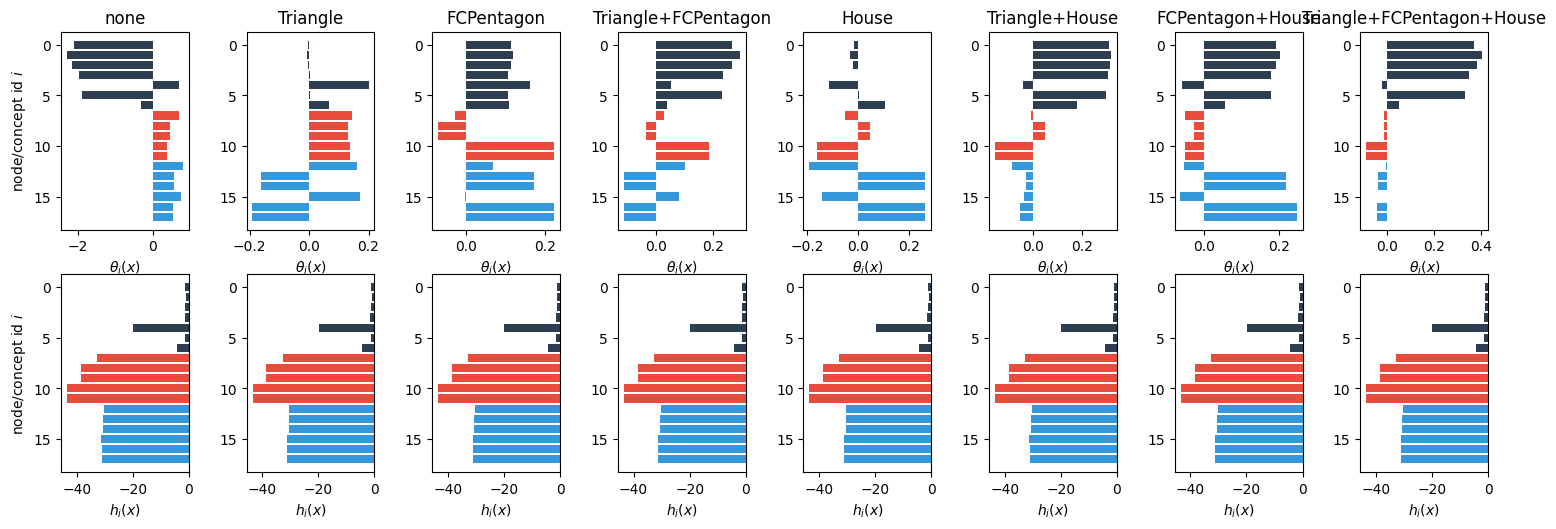

In [40]:
plot_theta_and_h(sample)

In [41]:
# print(np.round(x_out_all[batch_all==sample],decimals=2))

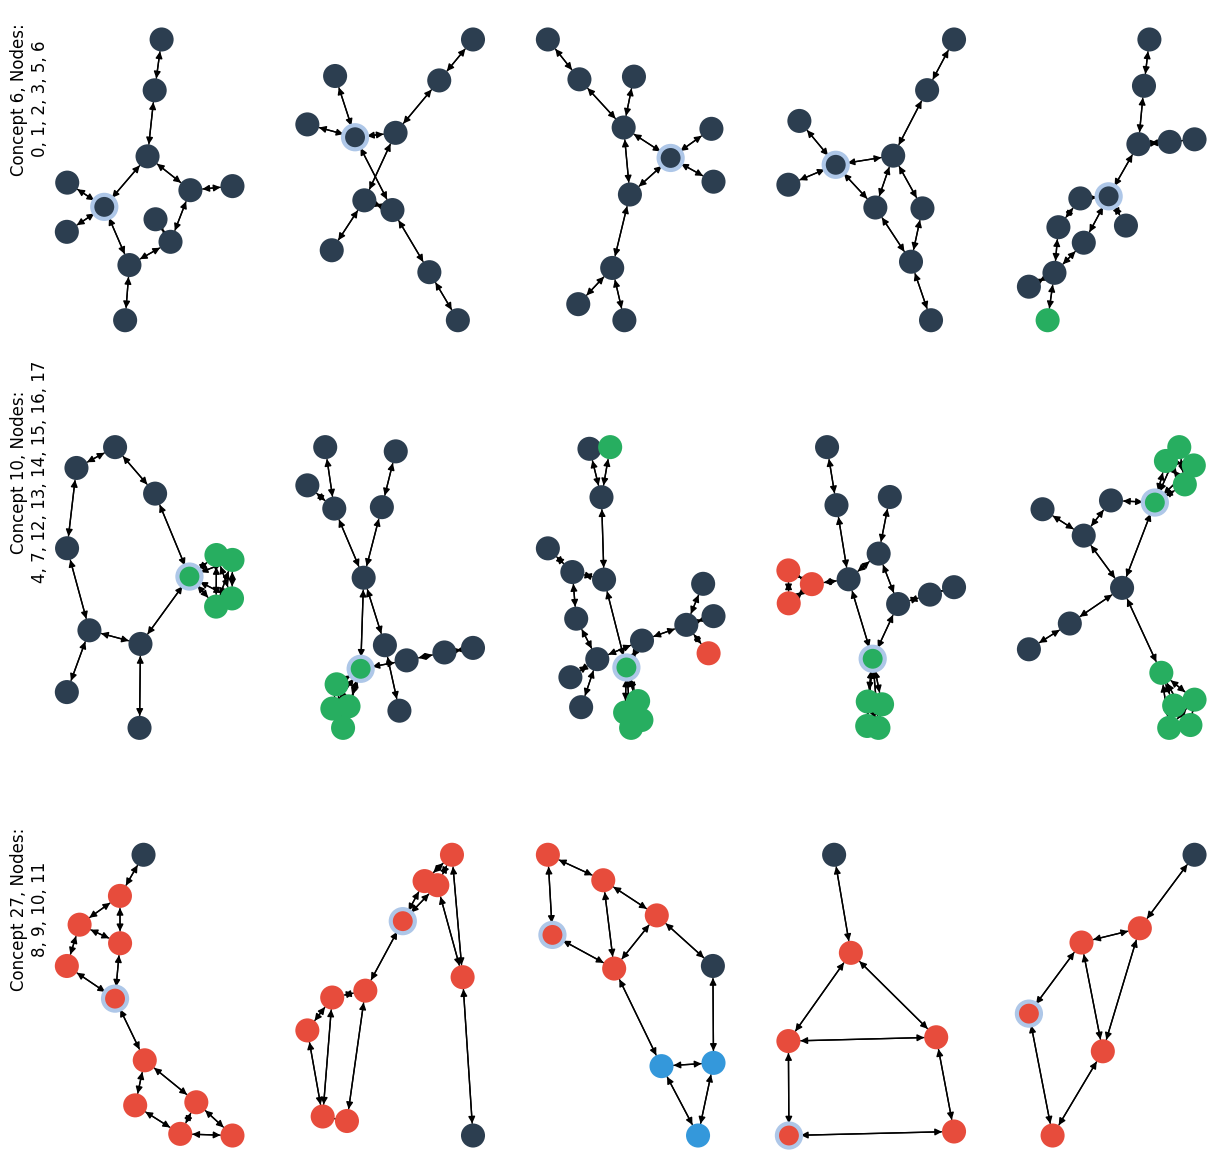

In [42]:
show_nearest_discretized(sample)

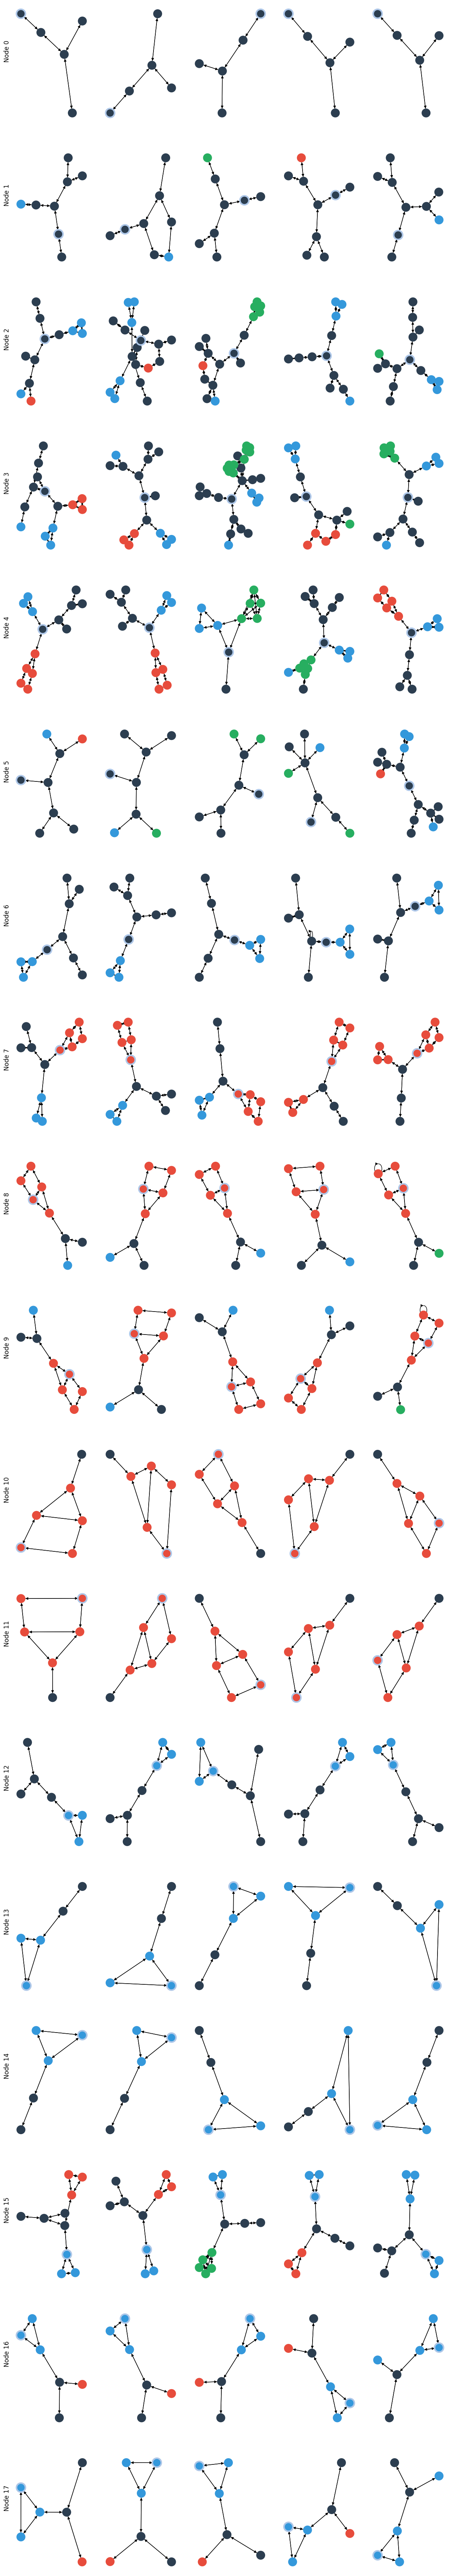

In [43]:
show_nearest(sample)